In [11]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [24]:
iris = load_iris()
X = iris['data']
y = iris['target']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=1)

# Standardize the features
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)

# print out
print(X_train[:2])
print(X_train_norm[:2])

[[5.1 3.4 1.5 0.2]
 [5.5 3.5 1.3 0.2]]
[[ 0.8389246  -0.02752244 -0.99590442 -1.65848156]
 [ 1.04279449  0.02344504 -1.09783936 -1.65848156]]


In [14]:
# Convert the standardized features and the labels into torch tensors
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)

print(X_train_norm.shape)
print(X_train_norm[:2])

# Create a PyTorch Dataset
train_dataset = TensorDataset(X_train_norm, y_train)

# Create a DataLoader
torch.manual_seed(1)
train_dl = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)

torch.Size([100, 4])
tensor([[ 0.8389, -0.0275, -0.9959, -1.6585],
        [ 1.0428,  0.0234, -1.0978, -1.6585]])


In [15]:
# Define the model
import torch
import torch.nn as nn

class ClassifierModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassifierModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

In [16]:
# Assuming X_train_norm.shape[1] is the input size for the dataset
input_size = X_train_norm.shape[1]
print(input_size)
hidden_size = 16
output_size = 3

# Initialize the model
model = ClassifierModel(input_size, hidden_size, output_size)

4


In [17]:
# Assuming model is already defined and train_dl is your DataLoader
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Training loop setup
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

# Training loop
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # prediction
        pred = model(x_batch)
        # compute loss
        loss = loss_fn(pred, y_batch)
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # compute store loss and accuracy
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
    
    # compute store loss and accuracy as percent
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

In [20]:
print(loss_hist)
print(accuracy_hist)

[1.130358556509018, 1.096763446331024, 1.0725008535385132, 1.0514727008342744, 1.0341388309001922, 1.0108109307289124, 0.986367324590683, 0.9600643861293793, 0.9306575345993042, 0.901714653968811, 0.8696074986457825, 0.836426523923874, 0.8033969318866729, 0.7697956371307373, 0.7366296708583832, 0.7068055152893067, 0.6777880096435547, 0.6519139641523362, 0.62618184030056, 0.6038665843009948, 0.585077342391014, 0.5639964380860328, 0.5494350108504296, 0.5320627012848854, 0.5189028251171112, 0.5051138713955879, 0.49216606497764587, 0.4813442438840866, 0.47190243780612945, 0.4602032071352005, 0.4516704884171486, 0.440070284307003, 0.4322190584242344, 0.4224557366967201, 0.4144306981563568, 0.40645878374576566, 0.39920451447367666, 0.3909571501612663, 0.3829121279716492, 0.3757618883252144, 0.3704587183892727, 0.3638406002521515, 0.35477720588445666, 0.34944149166345595, 0.3443624679744244, 0.33686900526285174, 0.3301844288408756, 0.3242835523188114, 0.31853527814149857, 0.3132592079043388, 

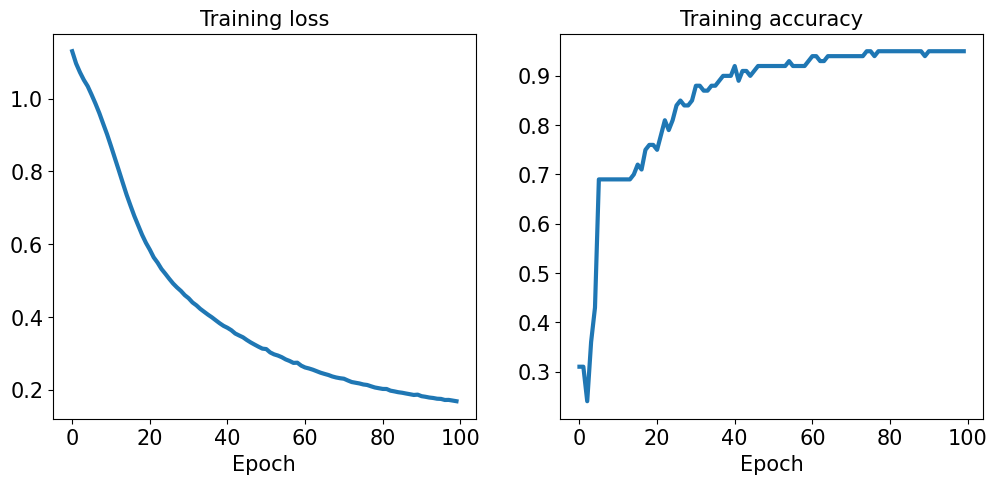

In [19]:
# Visualization setup
fig = plt.figure(figsize=(12, 5))

# Plot for training loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Plot for training accuracy
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [25]:
# Assuming X_test_norm is the standardized features of the test set
# and y_test is the actual labels for the test set
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test).float()

# Making predictions on the test set
pred_test = model(X_test_norm)
print(pred_test[:3])
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
print(correct[:3])
accuracy = correct.mean()

# Printing the test accuracy
print(f'Test Acc.: {accuracy:.4f}')

tensor([[ 5.0552,  0.8729, -6.1773],
        [ 0.0069,  1.1556, -3.9342],
        [-4.5942,  0.8247, -0.5700]], grad_fn=<SliceBackward0>)
tensor([1., 1., 1.])
Test Acc.: 0.9800


In [26]:
# Saving the trained model
path = 'models/iris_classifier_v1.pt'
torch.save(model, path)

ClassifierModel(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [27]:
# Reloading the trained model
model = torch.load(path)
model.eval()  # Set the model to evaluation mode

ClassifierModel(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [28]:
path = 'models/iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [30]:
model_new = ClassifierModel(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>

In [31]:
# Predict
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800
